### HEO Model : 1 Battery-1 Genset.
=========================================================================================================
$ 
\\
$

$ 
\\
$

### Optimization parameters.


$ Q_{\mathrm{max}} \hspace{1cm}$ : Maximal energy charge stored in battery (kWh)



$ Q_{\mathrm{init}} \hspace{1.1cm}$ : Initial energy charge stored on battery (kWh)



$ Q_{\mathrm{final}} \hspace{0.9cm}$ :  Final charge stored on battery (kWh)



$ P_{\mathrm{max}\;} \hspace{1cm}$ : Maximal power available from genset (kW)



${FC}_{max} \hspace{0.7cm}$ : Maximal fuel consumption (g/h)



$ {FC}_{offset} \hspace{0.4cm}$ : Offset for fuel consumption model at P=0)



$ a \hspace{1.7cm}$ : Slope in fuel consumption model



$ b \hspace{1.7cm}$ : Intercept in fuel consumption model (=)



$ K_{\mathrm{start}} \hspace{1cm}$ : Additional fuel consumption when starting genset (kg)



$ \Delta t \hspace{1.5cm}$ : Time step in discretization (h)




$ t_{\mathrm{max}\;} \hspace{1.1cm}$ : Max time in simulation (h)



$ n \hspace{1.7cm}$ :  Number of time steps in simulation



$ t_{\mathrm{max}\;} \hspace{1.1cm}$ : Max time in simulation (h)



$ t \hspace{1.8cm}$ :  Time vector in simulation (dim(t)=n)



$ \eta^{\mathrm{toBat}} \; \hspace{0.9cm}$ :  Efficiency when charging battery



$ \eta^{\mathrm{fromBat}} \; \hspace{0.5cm}$ :   Efficiency when battery is used for load



$ L \hspace{1.6cm}$ : Vector of pre-defined load profile (must be of same length as time vector, dim(L)=dim(t)=n) (kW)

$\newline$ 


### Optimization model.

$\mathrm{minimize}\;\;\;\;\;\sum_{k=1}^n {FC}_{k\;} \cdot \frac{\Delta t}{1000}+K_{\mathrm{start}} \sum_{k=2}^n z_k$  

$\newline$ 

Fuel consumption model 1 (linear):     $\hspace{1cm} {FC}_{k\;} ={aP}_{k\;} +b-{FC}_{offset} \cdot \left(1-y_k \right)\hspace{3cm}$      $k=1,\dots ,n$

Load requirements:     $\hspace{3.5cm}L_k =P_k^{\mathrm{load}} +\eta {\;}^{\mathrm{fromBat}} {\cdot \;P}_k^{\mathrm{fromBat}}\hspace{4.2cm}$      $k=1,\dots ,n$  


Power split:   $\hspace{4.8cm}P_{k\;} =P_k^{\mathrm{load}} {+\;P}_k^{\mathrm{toBat}}\hspace{6.3cm}$   $k=1,\dots ,n$

Charge balance (initial):   $\hspace{2.8cm}Q_0 =Q_{\mathrm{init}}\hspace{6.3cm}$  

Charge balance:  $\hspace{4cm}Q_k =Q_{k-1} +\eta^{\mathrm{toBat}} \cdot \;P_k^{\mathrm{toBat}} \Delta t-\;P_k^{\mathrm{fromBat}} \Delta t\hspace{1.8cm}$     $k=1,\dots ,n$ 


Charge balance (final):     $\hspace{3cm}Q_n =Q_{\mathrm{final}}\hspace{3cm}$   


Logical conditions on genset: $\hspace{2cm}P_{k\;} \le {0\ldotp 9P}_{\mathrm{max}\;} {\cdot y}_k\hspace{6.7cm}$    $k=1,\dots ,n$ 


(0 or in 0.2P_max - 0.9Pmax):  $\hspace{1.8cm}P_{k\;} \le {0\ldotp 2P}_{\mathrm{max}\;} {\cdot y}_k\hspace{6.8cm}$    $k=1,\dots ,n$




Logical conditions on battery:   $\hspace{1.9cm}y_k^{\mathrm{toBat}} +y_{k\;}^{\mathrm{fromBat}} \le 1\hspace{6.4cm}$     $k=1,\dots ,n$  $ \\$     
$\hspace{6.9cm}P_k^{\mathrm{toBat}} \le 0\ldotp 9P_{\mathrm{max}} {\cdot y}_k^{\mathrm{toBat}}\hspace{5.7cm}$ $k=1,\dots ,n$ 


$\hspace{6.9cm}P_k^{\mathrm{fromBat}} \le 0\ldotp 9P_{\mathrm{max}} {\cdot \;y}_k^{\mathrm{fromBat}}\hspace{4.8cm}$  $k=1,\dots ,n$ 

$\newline$ 


Constraints for linearization of objective:  $\hspace{0.5cm}z_k \ge y_k -y_{k-1}\hspace{7.0cm}$ $k=2,\ldotp \ldotp \ldotp ,n$

$\newline$ 

Variable bounds:  $\hspace{4.1cm}0\ldotp 2Q_{\mathrm{max}} \le Q_k \le Q_{\mathrm{max}}\hspace{5.8cm}$ $k=0,\ldotp \ldotp \ldotp ,n$  $ \\$  
$\hspace{7cm}0\le P_k \le 0\ldotp 9P_{\mathrm{max}}\hspace{6.5cm}$  $k=1,\ldotp \ldotp \ldotp ,n$    
 
$\hspace{7cm}0\le P_k^{\mathrm{toBat}} ,P_k^{\mathrm{fromBat}} \le {0\ldotp 9P}_{\mathrm{max}}\hspace{4.3cm}$ $k=1,\ldotp \ldotp \ldotp ,n$ 


$\hspace{7cm}0\le z_k \le 1\hspace{7.8cm}$  $k=2,\ldotp \ldotp \ldotp ,n$


$ \\$ Variable types:     $\hspace{1cm}Q_{k\}\,P_k^{\mathrm{toBat}} ,P_k^{\mathrm{fromBat}}} ,z_k$ :Continuous $\hspace{1cm}P_{k\}}$  :Semi-continuous  $\hspace{1.5cm}y_k ,y_k^{\mathrm{toBat}} ,y_k^{\mathrm{fromBat}}$ :Binary

$\newline$ 

 $ \\$ $P_k \hspace{2.1cm} $:  Power from genset during time step k
 
 $ \\$ $P_k^{\mathrm{toBat}}\hspace{1.5cm}$: Power to charge battery during time step k
 
 $ \\$ $P_k^{\mathrm{fromBat}}\hspace{1.2cm}$: Power delivered from battery during time step k
 
 $ \\$ $Q_k\hspace{2.1cm}$: Energy charge on battery at the end of time step k
 
 $ \\$ $y_k\hspace{2.1cm}$: Variable equal to 1 if genset is used in time step k, variable equal to 0 if genset not used in time step k

$ \\$ $y_k^{\mathrm{toBat}}\hspace{1.6cm}$: Variable equal to 1 if battery is charged under time step k

$ \\$ $y_k^{\mathrm{fromBat}}\hspace{1.1cm}$: Variable equal to 1 if battery if used for load in time step k

$ \\$ $z_k\hspace{1.9cm}$: Variable used to linearize additional cost when starting genset (  )



$\newline $
$\newline $




$\newline $
### Importing modules.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pulp import *
from gurobipy import *
from src.functions.fuel_consumption import fuelCon

### Python environment.

In [2]:

print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.10.9 | packaged by conda-forge | (main, Jan 11 2023, 15:15:40) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)


$\newline $
### Introducing problem Parameters.

In [4]:
Q_max = 250                                                   # Maximal capacity stored on battery.
Q_0 = 0.5*Q_max                                               # Inital capacity stored on battery.
Q_final = 0.5*Q_max                                           # Final capacity stored on the battery. 
eff_to_bat = 1                                                # Battery charging efficiency.
eff_from_bat = 1                                              # Battery transfer efficiency. 
P_A_max = 1000                                                # Max output from gen set A.
dt = 2/3                                                      # Simulation time step dt.
t_max = 5                                                     # Time span for simulation = t_max hours.
t = np.atleast_2d(np.arange(2,t_max,dt)).T.conj()             # Time scale in hours.
n = len(t)                                                    # Number of time steps.
m = 1                                                         # Number of Gensets used on the trip.
fc_j_offset = 12060                                           # Genset j fuel consumption when no power gnerated (p=0) in g/h.
K_j_start = 0.0                                               # Addicitional starting cost.
V_steps = [x for x in range (2,n)]                            # Time steps vector. 
V_steps_z = V_steps[:-1]                                      # Time steps vector without the final step. 


# Benchmarking Analysis: 6 different load Scenarios (for testing).

#L = {2:216, 3:350, 4:400} # Load Req Scenario 1 : l, MH, MH.
L = {2: 218, 3:70, 4:500} # Load Req Scenario 2 : L, LL, H.
#L = {2:520, 3: 236, 4: 650} # Load Req Scenario 3 : H, L, H.
#L = {2:70, 3:120, 4:40} # Load Req Scenario 4 : LL, LL, LL.
#L = {2:50, 3:23, 4:218} # Load Req Scenario 1 : LL, LL, L.
#L = {2:350, 3:100, 4:218} # Load Req Scenario 1* : L, LL, L.

$\newline $
### Creating the problem variable. 

In [5]:
Optim = LpProblem('Energy_Opt',LpMinimize)

$\newline $
### Slope, intercept and maximum fuel bound calculation.

In [6]:

a_j = (fuelCon(0.9*P_A_max, P_A_max) - fuelCon(0.2*P_A_max, P_A_max)) /(0.7*P_A_max) #slope.
b_j = fuelCon(0.2*P_A_max, P_A_max) - a_j*0.2*P_A_max #Intercept.
maxFC = fuelCon(0.9*P_A_max,P_A_max) # Max fuel bound.
print('FC Linear model caracteristics')
print('-----------------------------')
print('Slope =', a_j)
print('Intercept =', b_j)

FC Linear model caracteristics
-----------------------------
Slope = 186.3
Intercept = 12059.999999999993


$\newline $
### Setting-up decision Variables.

In [7]:
Q_bat = LpVariable.dicts("Q_bat", V_steps, lowBound=0.2*Q_max, upBound=Q_max, cat = LpContinuous)  # Battery charge at time step k.
P_From_bat = LpVariable.dicts("P_From_bat", V_steps, lowBound=0, upBound=0.9*P_A_max, cat = LpContinuous) # Power transfered from the battery to the load.
P_A = LpVariable.dicts("P_A", V_steps, lowBound=0, upBound=0.9*P_A_max, cat = LpContinuous)  # Power generated by the Genset A.
P_A_load = LpVariable.dicts("P_A_load", V_steps, lowBound=0, upBound=0.9*P_A_max, cat= LpContinuous) # Power transfered from the Genset A to the load at time step k.
Z =  LpVariable.dicts("Z", V_steps_z, lowBound=0, upBound=1, cat = LpInteger) # Aditional cost fuel oil consumption when starting Genset j.
FC_A = LpVariable.dicts("FC_A", V_steps, lowBound=0, upBound= maxFC, cat = LpContinuous) # Specific fuel oil consumption.
P_A_to_bat =  LpVariable.dicts("P_A_to_bat", V_steps, lowBound=0, upBound=0.9*P_A_max, cat = LpContinuous) 
Y_to_bat = LpVariable.dicts("Y_to_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter to charge the battery at time step k. 
Y_from_bat = LpVariable.dicts("Y_from_bat", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Battery selecter to transfert to the Genset j st time step k.
Y = LpVariable.dicts("Y", V_steps, lowBound=0, upBound=1, cat = LpInteger) # Genset selecter : work ==> Y=1, Not work ==> Y=0.

$\newline $
### Setting-up the objective function.

In [8]:
FC = sum(FC_A[k] for k in V_steps) * dt/1000  # sum of the fuel oil comsumption for all gensets over all k steps.
L_added_cost = sum(Z[i] for i in V_steps_z) * K_j_start  # Sum of all of the additional costs including starting costs. 
Optim += lpSum (FC + L_added_cost), "objective function minimization fuel oil consumption" 
print(FC)

0.0006666666666666666*FC_A_2 + 0.0006666666666666666*FC_A_3 + 0.0006666666666666666*FC_A_4


$\newline $
$\newline $
### Setting-up problem constraints.

In [10]:

for k in V_steps:

  # Fuel oil consumption constraint.
  Optim += FC_A[k] == P_A[k]*a_j + b_j - fc_j_offset*(1-Y[k]) 

  # Load requirements constraints
  Optim += P_A_load[k] + eff_from_bat*P_From_bat[k] == L[k]  
  Optim += P_A_load[k] + P_A_to_bat[k] == P_A[k] 


  # Genset logical constraints.
  Optim += P_A[k]  <= 0.9 * P_A_max * Y[k]
  Optim += P_A[k]  >= 0.2 * P_A_max * Y[k]

  # Battery charging logical constraints.
  Optim += P_A_to_bat[k] <= 0.9 * P_A_max * Y_to_bat[k]
  Optim += P_From_bat[k] <= 0.9 * P_A_max * Y_from_bat[k]
  Optim += Y_to_bat[k] + Y_from_bat[k]  <= 1
  

  # Charge balance logical constraints.
  if k == V_steps[0] : 
    Optim += Q_bat[k] == Q_0 + eff_to_bat*P_A_to_bat[k]*dt - P_From_bat[k]*dt


  else :   
    Optim += Q_bat[k] == Q_bat[k-1] + eff_to_bat*P_A_to_bat[k]*dt - P_From_bat[k]*dt

    
# Additional starting costs constraint.
for k in range(V_steps[0], V_steps[-1]): 
  Optim += Z[k] >= Y[k + 1] - Y[k] 
  
# Charge balance at the Final time step.
Optim += Q_bat[V_steps[-1]] == Q_final

$\newline $
$\newline $
### Solving the problem.

In [12]:
status = Optim.solve(GUROBI())

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i3-4000M CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 60 rows, 29 columns and 144 nonzeros
Model fingerprint: 0xb04bdb2e
Variable types: 18 continuous, 11 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-01, 1e+04]
  Objective range  [7e-04, 7e-04]
  Bounds range     [1e+00, 2e+05]
  RHS range        [7e-12, 5e+02]
Found heuristic solution: objective 113.9496000
Presolve removed 55 rows and 23 columns
Presolve time: 0.00s
Presolved: 5 rows, 6 columns, 12 nonzeros
Variable types: 4 continuous, 2 integer (2 binary)

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 1: 113.95 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.139496000000e+02, best bound 1.139496000000e+02, gap 0.0000%
Guro

$\newline $
$\newline $
### Printing optimization status.

In [13]:
LpStatus[status]

'Optimal'

$\newline $
$\newline $
### Printing constraints per each time step.

In [15]:
print(Optim.variables)

<bound method LpProblem.variables of Energy_Opt:
MINIMIZE
0.0006666666666666666*FC_A_2 + 0.0006666666666666666*FC_A_3 + 0.0006666666666666666*FC_A_4 + 0.0
SUBJECT TO
_C1: FC_A_2 - 186.3 P_A_2 - 12060 Y_2 = -7.27595761418e-12

_C2: P_A_load_2 + P_From_bat_2 = 218

_C3: - P_A_2 + P_A_load_2 + P_A_to_bat_2 = 0

_C4: P_A_2 - 900 Y_2 <= 0

_C5: P_A_2 - 200 Y_2 >= 0

_C6: P_A_to_bat_2 - 900 Y_to_bat_2 <= 0

_C7: P_From_bat_2 - 900 Y_from_bat_2 <= 0

_C8: Y_from_bat_2 + Y_to_bat_2 <= 1

_C9: - 0.666666666667 P_A_to_bat_2 + 0.666666666667 P_From_bat_2 + Q_bat_2
 = 125

_C10: FC_A_3 - 186.3 P_A_3 - 12060 Y_3 = -7.27595761418e-12

_C11: P_A_load_3 + P_From_bat_3 = 70

_C12: - P_A_3 + P_A_load_3 + P_A_to_bat_3 = 0

_C13: P_A_3 - 900 Y_3 <= 0

_C14: P_A_3 - 200 Y_3 >= 0

_C15: P_A_to_bat_3 - 900 Y_to_bat_3 <= 0

_C16: P_From_bat_3 - 900 Y_from_bat_3 <= 0

_C17: Y_from_bat_3 + Y_to_bat_3 <= 1

_C18: - 0.666666666667 P_A_to_bat_3 + 0.666666666667 P_From_bat_3 - Q_bat_2
 + Q_bat_3 = 0

_C19: FC_A_4 -

In [27]:
for v in Optim.variables():
    print(v.name, "=", v.varValue )

FC_A_2 = 65714.4
FC_A_3 = 0.0
FC_A_4 = 105210.0
P_A_2 = 288.0
P_A_3 = 0.0
P_A_4 = 500.0
P_A_load_2 = 218.0
P_A_load_3 = 0.0
P_A_load_4 = 500.0
P_A_to_bat_2 = 69.99999999999999
P_A_to_bat_3 = 0.0
P_A_to_bat_4 = 0.0
P_From_bat_2 = 0.0
P_From_bat_3 = 70.0
P_From_bat_4 = 0.0
Q_bat_2 = 171.66666666666669
Q_bat_3 = 125.0
Q_bat_4 = 125.0
Y_2 = 1.0
Y_3 = -0.0
Y_4 = 1.0
Y_from_bat_2 = 0.0
Y_from_bat_3 = 1.0
Y_from_bat_4 = 1.0
Y_to_bat_2 = 1.0
Y_to_bat_3 = -0.0
Y_to_bat_4 = -0.0
Z_2 = 1.0
Z_3 = 1.0


$\newline $
$\newline $
### Calculating the optimized fuel comsumption.

In [28]:
print("Total saved fuel comsumption of the trip:", value(Optim.objective),'kg') 

Total saved fuel comsumption of the trip: 113.9496 kg


$\newline $
### Pre-processing visualisation data.

In [29]:
# Constructing list out of the P_A vector.

P_A_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_A_'+ str(i)):
      P_A_list.append(v.varValue)
print(P_A_list)

# Constructing list out of the P_A_load vector.

P_A_load_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_A_load_'+ str(i)):
      P_A_load_list.append(v.varValue)
print(P_A_load_list)

# Constructing list out of the P_A_to_bat vector.

P_A_to_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_A_to_bat_'+ str(i)):
      P_A_to_bat_list.append(v.varValue)
print(P_A_to_bat_list)

# Constructing list out of the P_From_bat.

P_From_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('P_From_bat_'+ str(i)):
      P_From_bat_list.append(v.varValue)
print(P_From_bat_list)

# Constructing list out of the Q_bat vector.

Q_bat_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('Q_bat_'+ str(i)):
      Q_bat_list.append(v.varValue)
print(Q_bat_list)

# constructing list out of the FC_A vector.

FC_A_list = []
for v in Optim.variables():
  for i in V_steps:
    if v.name == ('FC_A_'+ str(i)):
      FC_A_list.append(v.varValue/1000)
print(FC_A_list)

# Constructing list out of load profil vector.

d_load_list = []              
for i in V_steps:
    d_load_list.append(L[i])
print(d_load_list)



[288.0, 0.0, 500.0]
[218.0, 0.0, 500.0]
[69.99999999999999, 0.0, 0.0]
[0.0, 70.0, 0.0]
[171.66666666666669, 125.0, 125.0]
[65.7144, 0.0, 105.21]
[218, 70, 500]


$\newline $

### Load requirement profil. 

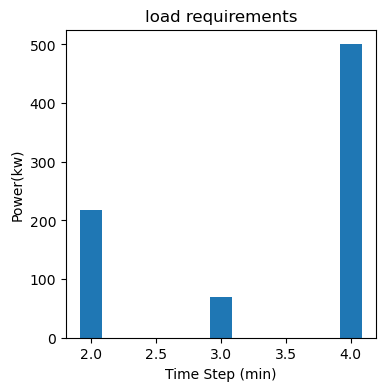

In [30]:
plt.rcParams["figure.figsize"] =  (4,4)
plt.bar(V_steps,d_load_list, width=0.17)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('load requirements')
plt.show()

In [31]:
print(V_steps,L)

[2, 3, 4] {2: 218, 3: 70, 4: 500}


$\newline $
### Generated genset power.

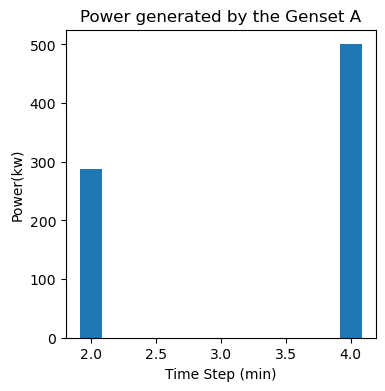

In [32]:
plt.rcParams["figure.figsize"] =  (4,4)
plt.bar(V_steps,P_A_list, width=0.17)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('Power generated by the Genset A')
plt.show()

In [33]:
print(V_steps,P_A_list)

[2, 3, 4] [288.0, 0.0, 500.0]


$\newline $
### Realised power from the genset to load.

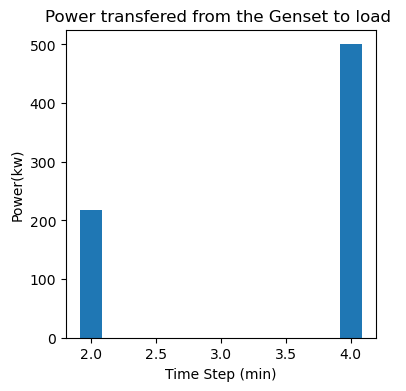

In [34]:
plt.rcParams["figure.figsize"] = (4,4)
plt.bar(V_steps,P_A_load_list, width=0.17)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('Power transfered from the Genset to load ')
plt.show()

In [35]:
print(V_steps,P_A_load_list)

[2, 3, 4] [218.0, 0.0, 500.0]


$\newline $
### Realised power to charge the battery.

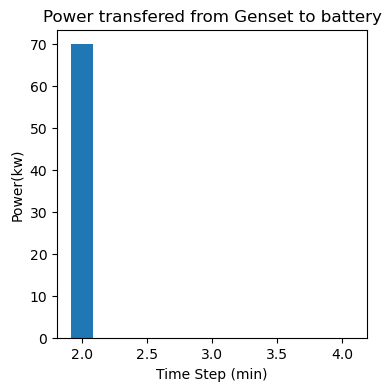

In [36]:
plt.rcParams["figure.figsize"] =  (4,4)                
plt.bar(V_steps,P_A_to_bat_list, width=0.17)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.xticks()
plt.title('Power transfered from Genset to battery')
plt.show()

In [37]:
print(V_steps,P_A_to_bat_list)

[2, 3, 4] [69.99999999999999, 0.0, 0.0]


$\newline $
### Realised power from the battery to load.

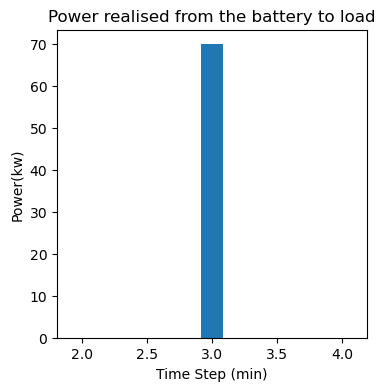

In [38]:
plt.rcParams["figure.figsize"] =  (4,4)
plt.bar(V_steps,P_From_bat_list, width=0.17)
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.title('Power realised from the battery to load')
plt.show()

In [39]:
print(V_steps,P_From_bat_list)

[2, 3, 4] [0.0, 70.0, 0.0]


### Battery charge balance.

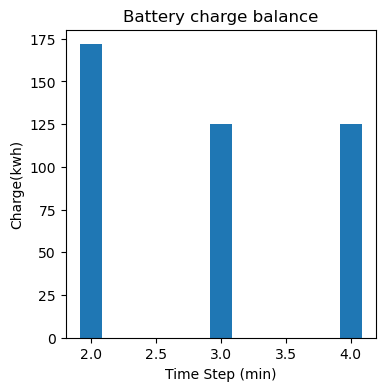

In [40]:
plt.rcParams["figure.figsize"] = (4,4)
plt.bar(V_steps,Q_bat_list, width=0.17)
plt.xlabel('Time Step (min)')
plt.ylabel('Charge(kwh)')
plt.title('Battery charge balance')
plt.show()

In [41]:
print(V_steps,Q_bat_list)

[2, 3, 4] [171.66666666666669, 125.0, 125.0]


$\newline $
### Genset fuel consumption.

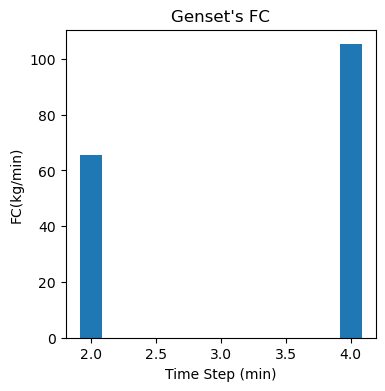

In [42]:
plt.rcParams["figure.figsize"] = (4,4)
plt.bar(V_steps,FC_A_list, width=0.17)
plt.xlabel('Time Step (min)')
plt.ylabel('FC(kg/min)')
plt.title("Genset's FC")
plt.show()

In [43]:
print(V_steps, FC_A_list)

[2, 3, 4] [65.7144, 0.0, 105.21]


In [44]:
print(sum(FC_A_list)*dt)

113.94959999999999


$\newline $
$\newline $
### Trip power flow bar chart.

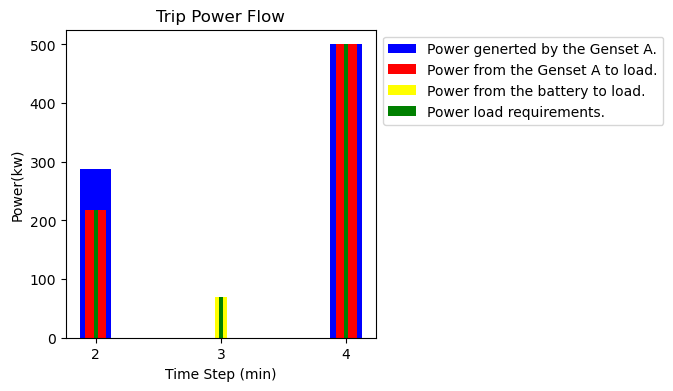

In [45]:
 
plt.rcParams["figure.figsize"] = (4,4)

gridnumber = V_steps

b1 = plt.bar(gridnumber, P_A_list, color="blue", width=0.25,
                label="Power generted by the Genset A.", align="center")

b2 = plt.bar(gridnumber, P_A_load_list, color="red", width=0.17,
                label="Power from the Genset A to load.", align="center")

b3 = plt.bar(gridnumber, P_From_bat_list, color="yellow", width=0.1,
                label="Power from the battery to load.", align="center")

b4 = plt.bar(gridnumber,d_load_list , color="green", width=0.03,
                label="Power load requirements.", align="center")

plt.title('Trip Power Flow')
plt.xlabel('Time Step (min)')
plt.ylabel('Power(kw)')
plt.xticks(gridnumber)
plt.legend(bbox_to_anchor= (1, 1))
plt.show()

